# Azure Cognitive Search Vector Search Code Sample - Ranking Analysis
This code demonstrates how to use Azure Cognitive Search with OpenAI and Azure Python SDK. Further, we manually calculate vector distances between embeddings generated for user queries, and indexed document vectors.
## Prerequisites
To run the code, install the following packages. Please use the latest pre-release version `pip install azure-search-documents --pre`.

In [ ]:
! pip install azure-search-documents --pre
! pip install openai
! pip install python-dotenv

## Import required libraries and environment variables

In [11]:
# Import required libraries  
import os  
import json  
import openai  
from dotenv import load_dotenv  
from tenacity import retry, wait_random_exponential, stop_after_attempt  
from azure.core.credentials import AzureKeyCredential  
from azure.search.documents import SearchClient  
from azure.search.documents.indexes import SearchIndexClient  
from azure.search.documents.models import Vector  
from azure.search.documents.indexes.models import (  
    SearchIndex,  
    SearchField,  
    SearchFieldDataType,  
    SimpleField,  
    SearchableField,  
    SearchIndex,  
    SemanticConfiguration,  
    PrioritizedFields,  
    SemanticField,  
    SearchField,  
    SemanticSettings,  
    VectorSearch,  
    HnswVectorSearchAlgorithmConfiguration,  
)  
  
# Configure environment variables  
load_dotenv()  
service_endpoint = 'https://{YOUR-SEARCH-SERVICE}.search.windows.net' # Cognitive Search Endpoint
index_name = '' # New Cognitive Search Index Name (for testing)
key = '' # Cognitive Search Key
openai.api_type = "azure"  
openai.api_key = '' # Azure OpenAI Key
openai.api_base = '' # Azure OpenAI Base
openai.api_version = '2023-07-01-preview' # Azure OpenAI API version
credential = AzureKeyCredential(key)

os.makedirs('./output', exist_ok=True)

## Create embeddings
Read your data, generate OpenAI embeddings and export to a format to insert your Azure Cognitive Search index:

In [4]:
# Generate Document Embeddings using OpenAI Ada 002
import time

# Read the text-sample.json
with open('./text-sample.json', 'r', encoding='utf-8') as file:
    input_data = json.load(file)

@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6))
# Function to generate embeddings for title and content fields, also used for query embeddings
def generate_embeddings(text):
    response = openai.Embedding.create(
        input=text, engine="text-embedding-ada-002")
    embeddings = response['data'][0]['embedding']
    return embeddings


# Generate embeddings for title and content fields
print(len(input_data))
for item in input_data:
    title = item['title']
    content = item['content']
    title_embeddings = generate_embeddings(title)
    time.sleep(.5)
    content_embeddings = generate_embeddings(content)
    item['titleVector'] = title_embeddings
    item['contentVector'] = content_embeddings
    time.sleep(.5)
    print(title)

# Output embeddings to docVectors.json file
with open("./output/docVectors.json", "w") as f:
    json.dump(input_data, f)

108
Azure App Service
Azure Functions
Azure Cognitive Services
Azure Storage
Azure SQL Database
Azure Cosmos DB
Azure Kubernetes Service (AKS)
Azure Virtual Machines
Azure DevOps
Azure IoT Hub
Azure Machine Learning
Azure Databricks
Azure Active Directory
Azure Logic Apps
Azure Event Hubs
Azure API Management
Azure Data Factory
Azure Synapse Analytics
Azure Batch
Azure CDN
Azure ExpressRoute
Azure Traffic Manager
Azure Virtual Network
Azure Firewall
Azure Private Link
Azure Site Recovery
Azure Backup
Azure Service Bus
Azure Stream Analytics
Azure Notification Hubs
Azure Mobile Apps
Azure Time Series Insights
Azure Digital Twins
Azure Data Explorer
Azure Data Catalog
Azure Data Lake Storage
Azure Data Lake Analytics
Azure Bastion
Azure Media Services
Azure Cognitive Search
Azure Key Vault
Azure Monitor
Azure DDoS Protection
Azure Application Gateway
Azure VPN Gateway
Azure HDInsight
Azure Power BI Embedded
Azure Managed Disks
Azure Cache for Redis
Azure Blob Storage
Azure File Storage
A

## Create your search index
Create your search index schema and vector search configuration.

NOTE: Here we are not using any additional semantic configuration, only vector lookup to validate efficacy of system in returning documents in the correct order based on vector similarity.

In [12]:
# Create a search index
index_client = SearchIndexClient(
    endpoint=service_endpoint, credential=credential)
fields = [
    SimpleField(name="id", type=SearchFieldDataType.String, key=True, sortable=True, filterable=True, facetable=True),
    SearchableField(name="title", type=SearchFieldDataType.String),
    SearchableField(name="content", type=SearchFieldDataType.String),
    SearchableField(name="category", type=SearchFieldDataType.String,
                    filterable=True),
    SearchField(name="titleVector", type=SearchFieldDataType.Collection(SearchFieldDataType.Single),
                searchable=True, vector_search_dimensions=1536, vector_search_configuration="my-vector-config"),
    SearchField(name="contentVector", type=SearchFieldDataType.Collection(SearchFieldDataType.Single),
                searchable=True, vector_search_dimensions=1536, vector_search_configuration="my-vector-config"),
]

# Omitting "metric" under HnswVectorSearchAlgorithmConfiguration parameters to confirm 
vector_search = VectorSearch(
    algorithm_configurations=[
        HnswVectorSearchAlgorithmConfiguration(
            name="my-vector-config",
            kind="hnsw",
            parameters={
                "m": 4,
                "efConstruction": 400,
                "efSearch": 500,
            }
        )
    ]
)

# Create the search index with the semantic settings
index = SearchIndex(name=index_name, fields=fields,
                    vector_search=vector_search)
result = index_client.create_or_update_index(index)
print(f' {result.name} created')


 scoring-test-index created


## Insert text and embeddings into vector store
Add texts and metadata from the JSON data to the vector store:

In [13]:
# Upload some documents to the index
with open('./output/docVectors.json', 'r') as file:  
    documents = json.load(file)  
search_client = SearchClient(endpoint=service_endpoint, index_name=index_name, credential=credential)
result = search_client.upload_documents(documents)  
print(f"Uploaded {len(documents)} documents") 

Uploaded 108 documents


## Perform a vector similarity search

In [24]:
import numpy as np

# Pure Vector Search
query = "tools for software development"  
  
search_client = SearchClient(service_endpoint, index_name, credential=credential)

vector = Vector(value=generate_embeddings(query), k=20, fields="contentVector")

results = search_client.search(  
            search_text=None,  
            vectors= [vector],
            select=["title", "content", "category", "contentVector"],
        )  
for res in results:
    print(res['title'])

Azure DevOps
Azure DevTest Labs
Azure Application Insights
Azure App Service
Azure Static Web Apps
Azure Mobile Apps
Azure API Management
Azure Logic Apps
Azure Service Fabric
Azure Machine Learning
Azure Quantum
Azure Sphere
Azure Data Factory
Azure Virtual Machines
Azure Blueprints
Azure Maps
Azure SignalR Service
Azure Functions
Azure App Configuration
Azure Cognitive Services


Metrics for calculating distances between vectors adapted from notebook @ https://github.com/Azure/cognitive-search-vector-pr/blob/main/demo-python/code/azure-search-vector-recall-python-sample.ipynb

In [27]:
from scipy.spatial.distance import cdist

search_embeddings = generate_embeddings(query)

results = search_client.search(  
            search_text=None,  
            vectors= [vector],
            select=["title", "content", "category", "contentVector"],
        )  

def calculate_query_response_distance(vector1, vector2, metric):
    return float(cdist(vector1, vector2, metric=metric)[0])

distances = []

for res in results:
    distance = calculate_query_response_distance([search_embeddings], [res['contentVector']], 'cosine')
    distances.append(distance)

Plot distance of top 20 returned document vectors to vector generated from user query text

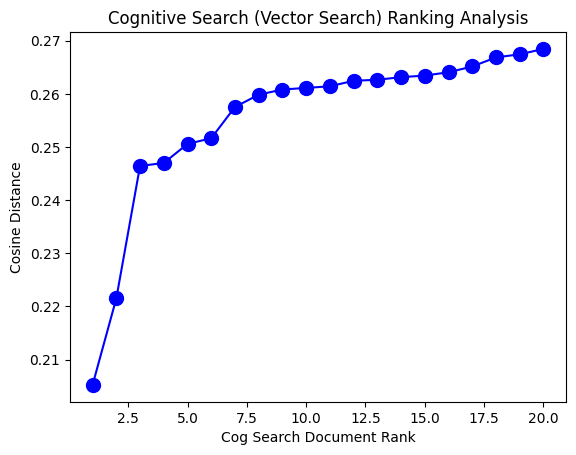

In [26]:
import matplotlib.pyplot as plt
import numpy as np


# Create an array of indices from 1 to n, where n is the length of values
indices = np.arange(1, len(distances) + 1)

# Plot the line with markers using the plot function
# You can specify the marker style, color, size, etc. using keyword arguments
# For a list of possible marker styles, see [Marker reference](https://matplotlib.org/stable/gallery/lines_bars_and_markers/marker_reference.html)
plt.plot(indices, distances, marker='o', color='blue', markersize=10)

# Set the axis labels and title using the xlabel, ylabel and title functions
plt.xlabel('Cog Search Document Rank')
plt.ylabel('Cosine Distance')
plt.title('Cognitive Search (Vector Search) Ranking Analysis')

# Show the plot using the show function
plt.show()